### This example demonstrates the use of experience replay with XCSF
Uses the [cart-pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) problem from OpenAI gymnasium (v.0.28.1)

```
$ pip install gymnasium[classic-control]

```

Note: These hyperparameters do not result in consistently optimal performance.

In [1]:
from __future__ import annotations

import random
from collections import deque
from typing import Final

import imageio
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image
from matplotlib import animation, rcParams
from tqdm import tqdm

import xcsf

### Initialise OpenAI Gym problem environment

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
X_DIM: Final[int] = env.observation_space.shape[0]
N_ACTIONS: Final[int] = env.action_space.n

### Initialise XCSF

In [3]:
# Supervised: i.e, single action; [A] = [M]
xcs: xcsf.XCS = xcsf.XCS(x_dim=X_DIM, y_dim=N_ACTIONS, n_actions=1)

xcs.OMP_NUM_THREADS = 12  # number of CPU cores to use
xcs.POP_INIT = False  # use covering to initialise
xcs.MAX_TRIALS = 1  # one trial per fit
xcs.POP_SIZE = 200  # maximum population size
xcs.E0 = 0.001  # target error
xcs.BETA = 0.05  # classifier parameter update rate
xcs.ALPHA = 1  # accuracy offset
xcs.NU = 5  # accuracy slope
xcs.EA_SUBSUMPTION = False
xcs.SET_SUBSUMPTION = False
xcs.THETA_EA = 100  # EA invocation frequency
xcs.THETA_DEL = 100  # min experience before fitness used for deletion

condition_layers: Final[dict] = {
    "layer_0": {  # hidden layer
        "type": "connected",
        "activation": "selu",
        "evolve_weights": True,
        "evolve_neurons": True,
        "n_init": 1,
        "n_max": 100,
        "max_neuron_grow": 1,
    },
    "layer_1": {  # output layer
        "type": "connected",
        "activation": "linear",
        "evolve_weights": True,
        "n_init": 1,
    },
}

xcs.condition("neural", condition_layers)  # neural network conditions
xcs.action("integer")  # (dummy) integer actions
xcs.prediction("rls_quadratic")  # Quadratic RLS

GAMMA: Final[float] = 0.95  # discount rate for delayed reward
epsilon: float = 1  # initial probability of exploring
EPSILON_MIN: Final[float] = 0.1  # the minimum exploration rate
EPSILON_DECAY: Final[float] = 0.98  # the decay of exploration after each batch replay
REPLAY_TIME: Final[int] = 1  # perform replay update every n episodes

print(xcs.json_parameters())

{
	"version":	"1.2.7",
	"x_dim":	4,
	"y_dim":	2,
	"n_actions":	1,
	"omp_num_threads":	12,
	"pop_init":	false,
	"max_trials":	1,
	"perf_trials":	1000,
	"pop_size":	200,
	"loss_func":	"mae",
	"set_subsumption":	false,
	"theta_sub":	100,
	"e0":	0.001,
	"alpha":	1,
	"nu":	5,
	"beta":	0.05,
	"delta":	0.1,
	"theta_del":	100,
	"init_fitness":	0.01,
	"init_error":	0,
	"m_probation":	10000,
	"stateful":	true,
	"compaction":	false,
	"ea":	{
		"select_type":	"roulette",
		"theta_ea":	100,
		"lambda":	2,
		"p_crossover":	0.8,
		"err_reduc":	1,
		"fit_reduc":	0.1,
		"subsumption":	false,
		"pred_reset":	false
	},
	"condition":	{
		"type":	"neural",
		"args":	{
			"layer_0":	{
				"type":	"connected",
				"activation":	"selu",
				"n_inputs":	4,
				"n_init":	1,
				"evolve_weights":	true,
				"evolve_functions":	false,
				"evolve_connect":	false,
				"evolve_neurons":	true,
				"n_max":	100,
				"max_neuron_grow":	1,
				"sgd_weights":	false
			},
			"layer_1":	{
				"type":	"connected",
				"acti

### Execute experiment

In [4]:
total_steps: int = 0  # total number of steps performed
MAX_EPISODES: Final[int] = 2000  # maximum number of episodes to run
N: Final[int] = 100  # number of episodes to average performance
memory: deque[tuple[np.ndarray, int, float, np.ndarray, bool]] = deque(maxlen=50000)
scores: deque[float] = deque(maxlen=N)  # used to calculate moving average

# for rendering an episode as a gif
SAVE_GIF: Final[bool] = True
SAVE_GIF_EPISODES: Final[int] = 50

frames: list[list[float]] = []
fscore: list[float] = []
ftrial: list[int] = []


def replay(replay_size: int = 5000) -> None:
    """Performs experience replay updates"""
    batch_size: Final[int] = min(len(memory), replay_size)
    batch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in batch:
        y_target = reward
        if not done:
            prediction_array = xcs.predict(next_state.reshape(1, -1))[0]
            y_target += GAMMA * np.max(prediction_array)
        target = xcs.predict(state.reshape(1, -1))[0]
        target[action] = y_target
        xcs.fit(state.reshape(1, -1), target.reshape(1, -1), shuffle=True)


def egreedy_action(state: np.ndarray) -> int:
    """Selects an action using an epsilon greedy policy"""
    if np.random.rand() < epsilon:
        return random.randrange(N_ACTIONS)
    prediction_array = xcs.predict(state.reshape(1, -1), cover=[0, 0])[0]
    # break ties randomly
    best_actions = np.where(prediction_array == prediction_array.max())[0]
    return int(np.random.choice(best_actions))


def episode(episode_nr: int, create_gif: bool) -> tuple[float, int]:
    """Executes a single episode, saving to memory buffer"""
    episode_score: float = 0
    episode_steps: int = 0
    state: np.ndarray = env.reset()[0]
    while True:
        action = egreedy_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_steps += 1
        episode_score += reward
        memory.append((state, action, reward, next_state, done))
        if create_gif:
            frames.append(env.render())
            fscore.append(episode_score)
            ftrial.append(episode_nr)
        if done:
            if create_gif:
                for _ in range(100):
                    frames.append(frames[-1])
                    fscore.append(fscore[-1])
                    ftrial.append(ftrial[-1])
            break
        state = next_state
    return episode_score, episode_steps


# learning episodes
for ep in range(MAX_EPISODES):
    gif: bool = False
    if SAVE_GIF and ep % SAVE_GIF_EPISODES == 0:
        gif = True
    # execute a single episode
    ep_score, ep_steps = episode(ep, gif)
    # perform experience replay updates
    if ep % REPLAY_TIME == 0:
        replay()
    # display performance
    total_steps += ep_steps
    scores.append(ep_score)
    mean_score = np.mean(scores)
    print(
        f"episodes={ep} "
        f"steps={total_steps} "
        f"score={mean_score:.2f} "
        f"epsilon={epsilon:.5f} "
        f"error={xcs.error():.5f} "
        f"msize={xcs.mset_size():.2f}"
    )
    # is the problem solved?
    if ep > N and mean_score > env.spec.reward_threshold:
        print(
            f"solved after {ep} episodes: "
            f"mean score {mean_score:.2f} > {env.spec.reward_threshold:.2f}"
        )
        break
    # decay the exploration rate
    if epsilon > EPSILON_MIN:
        epsilon *= EPSILON_DECAY

episodes=0 steps=17 score=17.00 epsilon=1.00000 error=0.33662 msize=0.92
episodes=1 steps=57 score=28.50 epsilon=0.98000 error=0.57833 msize=1.96
episodes=2 steps=82 score=27.33 epsilon=0.96040 error=0.55696 msize=3.65
episodes=3 steps=121 score=30.25 epsilon=0.94119 error=0.48284 msize=5.51
episodes=4 steps=138 score=27.60 epsilon=0.92237 error=0.56292 msize=9.02
episodes=5 steps=162 score=27.00 epsilon=0.90392 error=0.58491 msize=10.26
episodes=6 steps=211 score=30.14 epsilon=0.88584 error=0.32370 msize=15.70
episodes=7 steps=239 score=29.88 epsilon=0.86813 error=0.34875 msize=20.72
episodes=8 steps=313 score=34.78 epsilon=0.85076 error=0.36295 msize=26.72
episodes=9 steps=324 score=32.40 epsilon=0.83375 error=0.33375 msize=31.38
episodes=10 steps=338 score=30.73 epsilon=0.81707 error=0.30328 msize=37.84
episodes=11 steps=375 score=31.25 epsilon=0.80073 error=0.43557 msize=46.86
episodes=12 steps=402 score=30.92 epsilon=0.78472 error=0.30619 msize=56.03
episodes=13 steps=415 score=29

episodes=105 steps=31165 score=310.03 epsilon=0.11988 error=0.20250 msize=195.81
episodes=106 steps=31665 score=314.54 epsilon=0.11748 error=0.05453 msize=173.70
episodes=107 steps=32165 score=319.26 epsilon=0.11513 error=0.25119 msize=192.34
episodes=108 steps=32665 score=323.52 epsilon=0.11283 error=0.05835 msize=175.25
episodes=109 steps=33165 score=328.41 epsilon=0.11057 error=0.04661 msize=190.84
episodes=110 steps=33665 score=333.27 epsilon=0.10836 error=0.08810 msize=176.45
episodes=111 steps=34165 score=337.90 epsilon=0.10619 error=0.03864 msize=192.55
episodes=112 steps=34665 score=342.63 epsilon=0.10407 error=0.05451 msize=195.70
episodes=113 steps=35165 score=347.50 epsilon=0.10199 error=0.06661 msize=187.57
episodes=114 steps=35665 score=352.36 epsilon=0.09995 error=0.08406 msize=187.66
episodes=115 steps=36165 score=357.14 epsilon=0.09995 error=0.05349 msize=196.49
episodes=116 steps=36665 score=362.02 epsilon=0.09995 error=0.03915 msize=190.65
episodes=117 steps=37165 sco

### Final exploit episode

In [5]:
epsilon = 0
ep_score, ep_steps = episode(ep, SAVE_GIF)
print(f"score = {ep_score}, steps = {ep_steps}")

score = 500.0, steps = 500


### Render the learning episodes

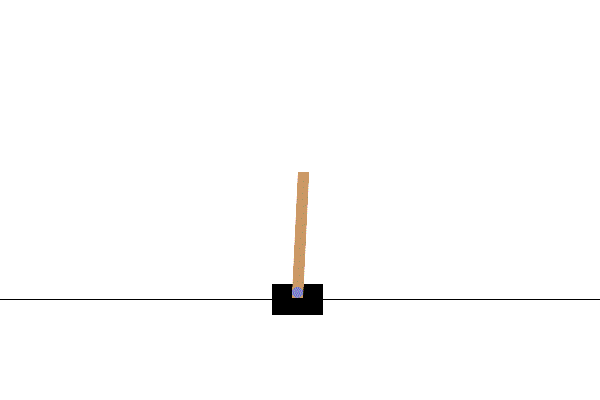

In [6]:
if SAVE_GIF:
    imageio.mimsave("animation.gif", frames)
    display(Image(open("animation.gif", "rb").read()))

In [7]:
env.close()  # close Gym